In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

# Метрики

In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)

def mae(y_true, y_pred):
    return np.mean(abs(y_true-y_pred))

def r2(y_true, y_pred):
    ssres = sum((y_true-y_pred)**2)
    sstotal = sum((y_true-np.mean(y_true))**2)
    return 1 - ssres/sstotal

# Загрузка датасета

In [4]:
data = pd.read_csv('Kharovsklesprom_data(1).csv', index_col=0, parse_dates=['Date'])
data.head()

,Date,Time,Usage_kWh
0,2017-01-01,00 - 01,570.685479
1,2017-01-01,01 - 02,604.642705
2,2017-01-01,02 - 03,518.732113
3,2017-01-01,03 - 04,608.188829
4,2017-01-01,04 - 05,714.140572


In [5]:
data.tail()

,Date,Time,Usage_kWh
35059,2020-12-31,19 - 20,1093.896979
35060,2020-12-31,20 - 21,976.242006
35061,2020-12-31,21 - 22,960.551132
35062,2020-12-31,22 - 23,694.074945
35063,2020-12-31,23 - 00,801.715216


In [6]:
test_shape = 24*7
test_shape

168

In [7]:
data2 = data[data.Date>='2020-09-01']
data2

,Date,Time,Usage_kWh
32136,2020-09-01,00 - 01,556.557509
32137,2020-09-01,01 - 02,404.583770
32138,2020-09-01,02 - 03,381.236165
32139,2020-09-01,03 - 04,503.773765
32140,2020-09-01,04 - 05,349.673520
...,...,...,...
35059,2020-12-31,19 - 20,1093.896979
35060,2020-12-31,20 - 21,976.242006
35061,2020-12-31,21 - 22,960.551132
35062,2020-12-31,22 - 23,694.074945


In [8]:
y_test = data[-test_shape:]['Usage_kWh'] # 24*7
y = data2[data2['Date'] <= '2020-12-24']['Usage_kWh'] # до 24 вкл
y25 = data2[data2['Date'] <= '2020-12-25']['Usage_kWh'] # до 25 вкл
y26 = data2[data2['Date'] <= '2020-12-26']['Usage_kWh'] # до 26 вкл
y27 = data2[data2['Date'] <= '2020-12-27']['Usage_kWh'] # до 27 вкл
y28 = data2[data2['Date'] <= '2020-12-28']['Usage_kWh'] # до 28 вкл
y29 = data2[data2['Date'] <= '2020-12-29']['Usage_kWh'] # до 29 вкл
y30 = data2[data2['Date'] <= '2020-12-30']['Usage_kWh'] # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

In [11]:
dates_list = []
for d in data[-test_shape:]['Date']:
    if d not in dates_list:
        dates_list.append(d)

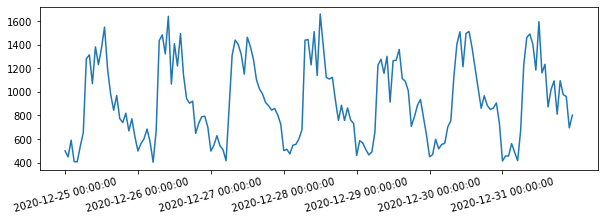

In [12]:
plt.figure(figsize=(10,3))
plt.plot(y_test.values)
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

# Стационарность

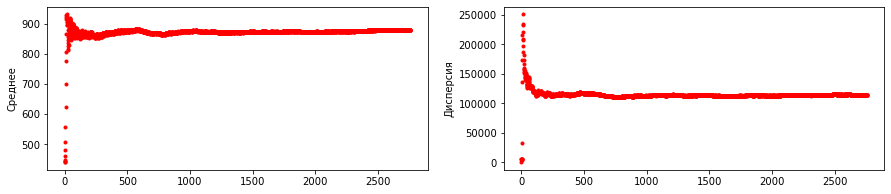

In [29]:
plt.figure(figsize=(15, 3))
m, v = [], []
for i in range(1, len(y)):
    x = y[:i]
    m.append(np.mean(x))
    v.append(np.var(x))
plt.subplot(1,2,1)
plt.scatter(range(len(m)), m, color='red', marker='.')
plt.ylabel('Среднее')

plt.subplot(1,2,2)
plt.scatter(range(len(v)), v, color='red', marker='.')
plt.ylabel('Дисперсия');

In [30]:
test = adfuller(y)
print('ADF: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4], '\n')
if test[0]> test[4]['5%']: 
    print('Есть единичные корни => ряд не стационарен')
else:
    print('Единичных корней нет => ряд стационарен')

ADF:  -6.950956302048816
p-value:  9.695911231476158e-10
Critical values:  {'1%': -3.4327458473129906, '5%': -2.86259851213211, '10%': -2.5673334803017864} 

Единичных корней нет => ряд стационарен


# ACF

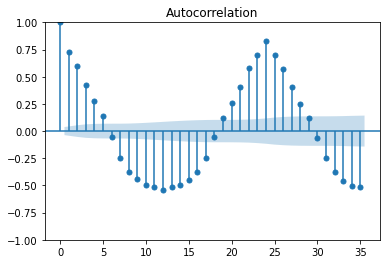

In [31]:
plot_acf(y)
plt.title('Autocorrelation')
plt.show()

Кэффициенты лагов уменьшаеются не резко, следовательно, процесс не только MA

# PACF

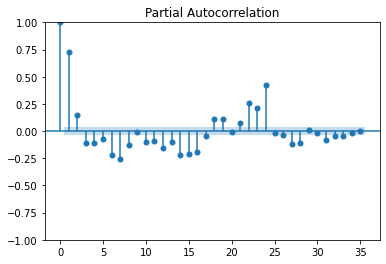

In [32]:
plot_pacf(y)
plt.title('Partial Autocorrelation')
plt.show()

Наблюдается синусоида, слдеовательно, процесс не чисто AR

# Переходим к ARMA

# Поиск p и q

In [33]:
col = ['Order', 'AIC', 'Prob(Q)', 'P>|z|']
col

['Order', 'AIC', 'Prob(Q)', 'P>|z|']

In [34]:
df_results = pd.DataFrame(None,
                          columns=col)
start_search = time.time()
for p_i in range(4):
    for q_i in range(4):

        try:
            model = ARIMA(y, order=(p_i, 0, q_i)).fit()
            residuals = model.resid
            res = {}
            res['Order'] = (p_i,0,q_i)
            res['AIC'] = round(model.aic, 2)
            res['Prob(Q)'] = '>0.05' if acorr_ljungbox(residuals, lags=1, return_df=True)['lb_pvalue'].values[0] > 0.05 else '<0.05'
            res['P>|z|'] = 'all' if sum(model.pvalues < 0.05)==len(model.pvalues) else 'not all'
            df_results = df_results.append(res,
                                            ignore_index=True)
            print(f'Order: ({p_i},0,{q_i})       AIC: {model.aic:.2f}')
        except:
            continue
end_search = time.time()
print('\n\nПеребор параметров занял: ', end_search-start_search)

Order: (0,0,0)       AIC: 39980.88
Order: (0,0,1)       AIC: 38813.67
Order: (0,0,2)       AIC: 38228.18
Order: (0,0,3)       AIC: 37945.79
Order: (1,0,0)       AIC: 37904.94
Order: (1,0,1)       AIC: 37861.96
Order: (1,0,2)       AIC: 37806.63
Order: (1,0,3)       AIC: 37808.55
Order: (2,0,0)       AIC: 37844.67
Order: (2,0,1)       AIC: 37831.55
Order: (2,0,2)       AIC: 37333.22
Order: (2,0,3)       AIC: 37809.84
Order: (3,0,0)       AIC: 37810.95
Order: (3,0,1)       AIC: 37450.40
Order: (3,0,2)       AIC: 37794.58
Order: (3,0,3)       AIC: 37795.93


Перебор параметров занял:  19.81971788406372


In [35]:
df_results = df_results.sort_values(by='AIC', ascending=True)
df_results

,Order,AIC,Prob(Q),P>|z|
10,"(2, 0, 2)",37333.22,<0.05,all
13,"(3, 0, 1)",37450.40,>0.05,all
14,"(3, 0, 2)",37794.58,>0.05,not all
15,"(3, 0, 3)",37795.93,>0.05,not all
6,"(1, 0, 2)",37806.63,>0.05,all
7,"(1, 0, 3)",37808.55,>0.05,not all
11,"(2, 0, 3)",37809.84,>0.05,not all
12,"(3, 0, 0)",37810.95,>0.05,all
9,"(2, 0, 1)",37831.55,>0.05,all
8,"(2, 0, 0)",37844.67,>0.05,all


In [36]:
df_good_results = df_results[df_results['P>|z|'] == 'all']
df_good_results = df_good_results[df_good_results['Prob(Q)'] == '>0.05']
df_good_results

,Order,AIC,Prob(Q),P>|z|
13,"(3, 0, 1)",37450.40,>0.05,all
6,"(1, 0, 2)",37806.63,>0.05,all
12,"(3, 0, 0)",37810.95,>0.05,all
9,"(2, 0, 1)",37831.55,>0.05,all
8,"(2, 0, 0)",37844.67,>0.05,all
5,"(1, 0, 1)",37861.96,>0.05,all
3,"(0, 0, 3)",37945.79,>0.05,all


In [37]:
# df_results.sort_values(by='AIC', ascending=True).to_csv('Выбор_модели_ARIMA.csv')

In [38]:
# df_results = pd.read_csv('/content/drive/MyDrive/ВКР/Выбор_модели_ARIMA.csv', index_col=0)
# df_results

In [39]:
# предсказания и замер времени на предсказание
df_arima_predictions = pd.DataFrame(None)
df_arima_predictions['True'] = y_test.values

time_prediction_list = []

for order in df_good_results.Order:
    print(f'\nOrder: {order}')
    week_pred = []
    for day in range(7):
        print(f'Day: {day+1}')
        y_pred = [] # предсказанный 1 день
        y_for_train = list(y_list[day])
        start_pred = time.time()
        for i in range(len(y_list[day]), len(y_list[day])+24):
            model = ARIMA(y_for_train, order=order).fit()
            prediction = model.predict(i)
            y_pred.append(prediction.item())
            y_for_train.extend(prediction)
            print(i)
        week_pred.extend(y_pred)

    end_pred = time.time()
    time_prediction_list.append(end_pred-start_pred)
    df_arima_predictions[order] = week_pred


Order: (3, 0, 1)
Day: 1
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
Day: 2
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
Day: 3
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
Day: 4
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
Day: 5
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
Day: 6
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
Day: 7
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927

Order: (1, 0, 2)
Day: 1
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
277

In [40]:
df_arima_predictions

,True,"(3, 0, 1)","(1, 0, 2)","(3, 0, 0)","(2, 0, 1)","(2, 0, 0)","(1, 0, 1)","(0, 0, 3)"
0,498.574076,658.951175,765.225768,763.290277,765.996152,767.898318,766.275467,759.034950
1,448.325927,621.422564,778.237441,778.669734,783.081983,786.330138,789.466321,782.445881
2,589.959784,607.346318,805.869420,808.467685,806.647772,805.320726,807.925172,842.156947
3,408.063429,613.444983,825.995354,825.533095,820.558579,819.816020,822.617570,880.055788
4,406.263067,637.001407,840.653943,841.171233,833.739358,831.614981,834.312048,880.040496
...,...,...,...,...,...,...,...,...
163,1093.896979,925.165796,881.938459,881.982914,881.034367,880.649869,880.920596,882.304190
164,976.242006,906.294399,882.021159,882.055683,881.280673,880.956384,881.185634,882.304190
165,960.551132,888.283124,882.081433,882.108086,881.475433,881.202996,881.396708,882.304190
166,694.074945,872.249091,882.125361,882.145830,881.629451,881.401411,881.564805,882.304191


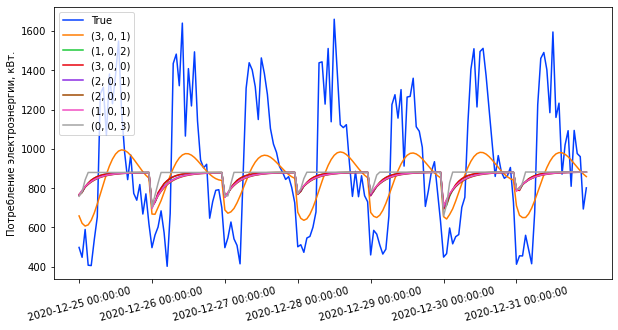

In [41]:
plt.figure(figsize=(10, 5))
colors = sns.color_palette("bright", n_colors=len(df_arima_predictions.columns))
for i, col in enumerate(df_arima_predictions):
    plt.plot(df_arima_predictions[col], color=colors[i], label=col)
plt.ylabel('Потребление электроэнергии, кВт.')
plt.legend()
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

In [42]:
mape_list = [mape(y_test.values, df_arima_predictions[col].values) for col in df_arima_predictions.columns[1:]]
mse_list = [mse(y_test.values, df_arima_predictions[col].values) for col in df_arima_predictions.columns[1:]]
mae_list = [mae(y_test.values, df_arima_predictions[col].values) for col in df_arima_predictions.columns[1:]]
r2_list = [r2(y_test.values, df_arima_predictions[col].values) for col in df_arima_predictions.columns[1:]]

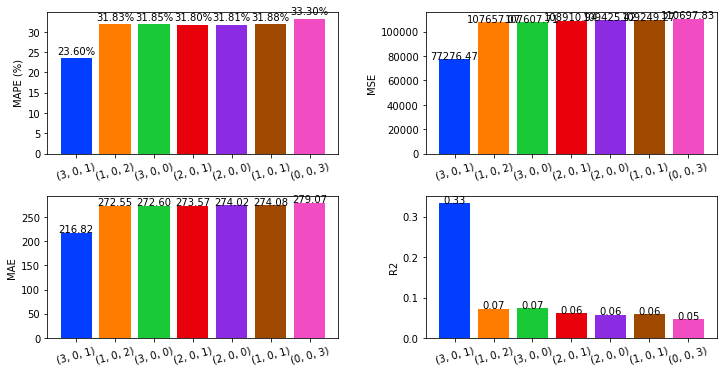

In [43]:
plt.figure(figsize=(12, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
xnames = [str(col) for col in df_arima_predictions.columns[1:]]

plt.subplot(2, 2, 1)
plt.bar(x=xnames, height=mape_list, color=colors)
for index, value in enumerate(mape_list):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(xnames, rotation=15)

plt.subplot(2, 2, 2)
plt.bar(x=xnames, height=mse_list, color=colors)
for index, value in enumerate(mse_list):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(xnames, rotation=15)

plt.subplot(2, 2, 3)
plt.bar(x=xnames, height=mae_list, color=colors)
for index, value in enumerate(mae_list):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(xnames, rotation=15)

plt.subplot(2, 2, 4)
plt.bar(x=xnames, height=r2_list, color=colors)
for index, value in enumerate(r2_list):
    plt.text(x=index, y=value , s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(xnames, rotation=15);

In [44]:
# sum_list = [sum(df_arima_predictions[col]) for col in df_arima_predictions.columns[1:]]
# plt.bar(x=xnames, height=sum_list, color=colors)
# plt.hlines(y=sum(y_test), xmin=-0.5, xmax=len(df_arima_predictions.columns)-1.5, color='black', linestyles='dashed')
# for index, value in enumerate(sum_list):
#     plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
# plt.text(x=3, y=25_000, s=f'sum(y_true)={sum(df_arima_predictions["True"]):.0f}', ha='center')
# plt.ylabel('Сумма за день');

In [45]:
df_arima_results = pd.DataFrame(None)
df_arima_results['Model'] = [f'ARIMA{order}'for order in xnames]
df_arima_results['MAPE'] = mape_list
df_arima_results['MSE'] = mse_list
df_arima_results['MAE'] = mae_list
df_arima_results['R2'] = r2_list
df_arima_results['Time_prediction'] = time_prediction_list
# df_arima_results['Sum'] = sum_list
df_arima_results.to_csv('Итог_ARIMA_модели.csv')

# Сезонность

## Поиск p и q при P=1

In [46]:
col = ['Order', 'AIC', 'Prob(Q)', 'P>|z|']
col

['Order', 'AIC', 'Prob(Q)', 'P>|z|']

In [47]:
df_results = pd.DataFrame(None,
                          columns=col)
start_search = time.time()
for p_i in range(4):
    for q_i in range(4):

        try:
            model = ARIMA(y, order=(p_i, 0, q_i), seasonal_order=(1,0,0,24)).fit()
            residuals = model.resid
            res = {}
            res['Order'] = (p_i,0,q_i)
            res['AIC'] = round(model.aic, 2)
            res['Prob(Q)'] = '>0.05' if acorr_ljungbox(residuals, lags=1, return_df=True)['lb_pvalue'].values[0] > 0.05 else '<0.05'
            res['P>|z|'] = 'all' if sum(model.pvalues < 0.05)==len(model.pvalues) else 'not all'
            df_results = df_results.append(res,
                                            ignore_index=True)
            print(f'Order: ({p_i},0,{q_i})(1,0,0)[24]       AIC: {model.aic:.2f}')
        except:
            continue
end_search = time.time()
print('\n\nПеребор параметров занял: ', end_search-start_search)

Order: (0,0,0)(1,0,0)[24]       AIC: 36667.01
Order: (0,0,1)(1,0,0)[24]       AIC: 36585.76
Order: (0,0,2)(1,0,0)[24]       AIC: 36548.00
Order: (0,0,3)(1,0,0)[24]       AIC: 36501.62
Order: (1,0,0)(1,0,0)[24]       AIC: 36557.88
Order: (1,0,1)(1,0,0)[24]       AIC: 36465.32
Order: (1,0,2)(1,0,0)[24]       AIC: 36462.42
Order: (1,0,3)(1,0,0)[24]       AIC: 36450.88
Order: (2,0,0)(1,0,0)[24]       AIC: 36498.74
Order: (2,0,1)(1,0,0)[24]       AIC: 36463.52
Order: (2,0,2)(1,0,0)[24]       AIC: 36196.67
Order: (2,0,3)(1,0,0)[24]       AIC: 36140.53
Order: (3,0,0)(1,0,0)[24]       AIC: 36459.52
Order: (3,0,1)(1,0,0)[24]       AIC: 36482.87
Order: (3,0,2)(1,0,0)[24]       AIC: 36161.50
Order: (3,0,3)(1,0,0)[24]       AIC: 36319.31


Перебор параметров занял:  196.14620280265808


In [48]:
df_results = df_results.sort_values(by='AIC', ascending=True)
df_results

,Order,AIC,Prob(Q),P>|z|
11,"(2, 0, 3)",36140.53,>0.05,all
14,"(3, 0, 2)",36161.50,>0.05,all
10,"(2, 0, 2)",36196.67,<0.05,all
15,"(3, 0, 3)",36319.31,<0.05,all
7,"(1, 0, 3)",36450.88,>0.05,not all
12,"(3, 0, 0)",36459.52,>0.05,all
6,"(1, 0, 2)",36462.42,>0.05,all
9,"(2, 0, 1)",36463.52,>0.05,not all
5,"(1, 0, 1)",36465.32,>0.05,all
13,"(3, 0, 1)",36482.87,>0.05,all


In [49]:
df_good_results = df_results[df_results['P>|z|'] == 'all']
df_good_results = df_good_results[df_good_results['Prob(Q)'] == '>0.05']
df_good_results

,Order,AIC,Prob(Q),P>|z|
11,"(2, 0, 3)",36140.53,>0.05,all
14,"(3, 0, 2)",36161.50,>0.05,all
12,"(3, 0, 0)",36459.52,>0.05,all
6,"(1, 0, 2)",36462.42,>0.05,all
5,"(1, 0, 1)",36465.32,>0.05,all
13,"(3, 0, 1)",36482.87,>0.05,all
8,"(2, 0, 0)",36498.74,>0.05,all
3,"(0, 0, 3)",36501.62,>0.05,all
2,"(0, 0, 2)",36548.00,>0.05,all
4,"(1, 0, 0)",36557.88,>0.05,all


In [50]:
# предсказания и замер времени на предсказание
df_seasonal_arima_predictions = pd.DataFrame(None)
df_seasonal_arima_predictions['True'] = y_test.values

time_prediction_list = []

for order in df_good_results.Order:
    print(f'\nOrder: {order}')
    week_pred = []
    for day in range(7):
        print(f'Day: {day+1}')
        
        y_pred = []
        y_for_train = list(y_list[day])
        start_pred = time.time()
        for i in range(len(y_list[day]), len(y_list[day])+24):
            try:
                model = ARIMA(y_for_train, order=order, seasonal_order=(1,0,0,24)).fit()
            except:
                model = ARIMA(y_for_train, order=order, seasonal_order=(1,0,0,24))
                model.initialize_approximate_diffuse()
                model = model.fit()

            prediction = model.predict(i)
            y_pred.append(prediction.item())
            y_for_train.extend(prediction)
        week_pred.extend(y_pred)

    end_pred = time.time()
    time_prediction_list.append(end_pred-start_pred)
    df_seasonal_arima_predictions[f'{order}'] = week_pred


Order: (2, 0, 3)
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7

Order: (3, 0, 2)
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7

Order: (3, 0, 0)
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7

Order: (1, 0, 2)
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7

Order: (1, 0, 1)
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7

Order: (3, 0, 1)
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7

Order: (2, 0, 0)
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7

Order: (0, 0, 3)
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7

Order: (0, 0, 2)
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7

Order: (1, 0, 0)
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7

Order: (0, 0, 1)
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [51]:
df_seasonal_arima_predictions

,True,"(2, 0, 3)","(3, 0, 2)","(3, 0, 0)","(1, 0, 2)","(1, 0, 1)","(3, 0, 1)","(2, 0, 0)","(0, 0, 3)","(0, 0, 2)","(1, 0, 0)","(0, 0, 1)"
0,498.574076,525.289360,537.616779,580.904613,583.547563,585.264850,548.007121,587.314431,568.890229,574.173152,579.561813,568.018114
1,448.325927,540.826219,545.760054,627.174037,629.257758,628.260179,583.999506,634.701539,620.697230,621.428957,616.942124,605.567756
2,589.959784,584.837846,577.783006,674.137138,671.076132,670.340268,618.564466,672.447078,668.308571,658.705141,659.728020,651.834729
3,408.063429,565.789310,542.126286,610.479433,609.932842,608.828173,565.601334,612.473708,601.693591,595.894723,596.583224,587.076468
4,406.263067,600.383217,570.255708,621.308329,620.154755,619.073079,569.590069,622.359163,612.802372,607.237228,607.799113,598.773236
...,...,...,...,...,...,...,...,...,...,...,...,...
163,1093.896979,877.110440,880.436075,883.948458,883.992049,884.042038,856.809843,883.945406,883.990147,884.017463,884.014013,884.056041
164,976.242006,779.803226,820.665738,858.601909,858.422481,858.321288,836.725525,858.689050,857.913951,857.397089,857.440758,856.631172
165,960.551132,788.319287,790.580488,867.272973,867.159576,867.099497,850.239748,867.329107,866.832418,866.501610,866.529002,866.010418
166,694.074945,786.713466,782.055651,899.709402,899.866179,899.981201,882.821724,899.650747,900.200568,900.564445,900.532145,901.102868


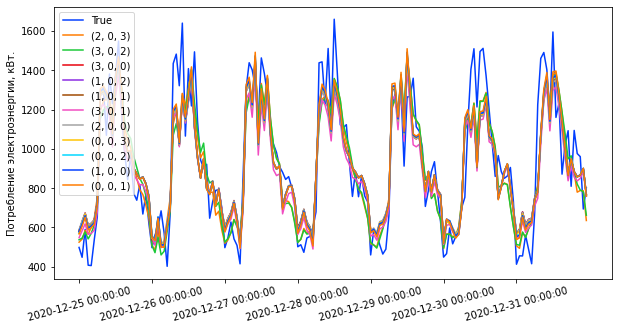

In [53]:
plt.figure(figsize=(10, 5))
colors = sns.color_palette("bright", n_colors=len(df_seasonal_arima_predictions.columns))
for i, col in enumerate(df_seasonal_arima_predictions):
    plt.plot(df_seasonal_arima_predictions[col], color=colors[i], label=col)
plt.ylabel('Потребление электроэнергии, кВт.')
plt.legend()
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

In [54]:
mape_list = [mape(y_test.values, df_seasonal_arima_predictions[col].values) for col in df_seasonal_arima_predictions.columns[1:]]
mse_list = [mse(y_test.values, df_seasonal_arima_predictions[col].values) for col in df_seasonal_arima_predictions.columns[1:]]
mae_list = [mae(y_test.values, df_seasonal_arima_predictions[col].values) for col in df_seasonal_arima_predictions.columns[1:]]
r2_list = [r2(y_test.values, df_seasonal_arima_predictions[col].values) for col in df_seasonal_arima_predictions.columns[1:]]

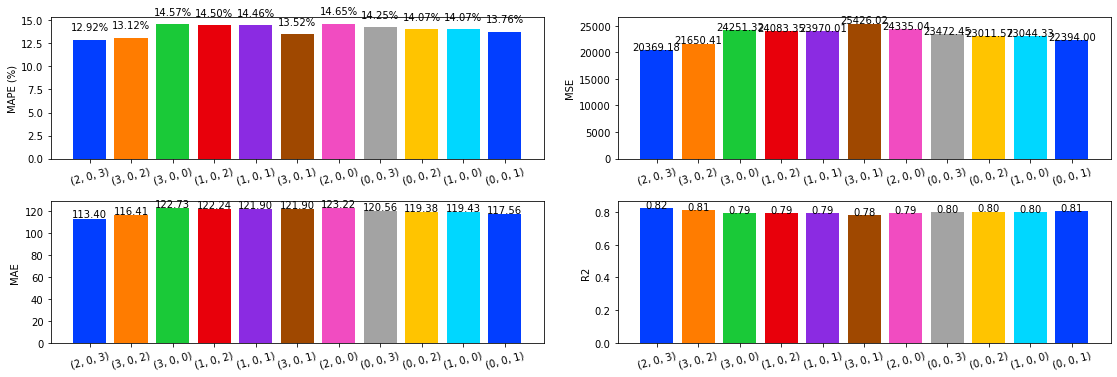

In [61]:
plt.figure(figsize=(19, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.15)
xnames = [str(col) for col in df_seasonal_arima_predictions.columns[1:]]

plt.subplot(2, 2, 1)
plt.bar(x=xnames, height=mape_list, color=colors)
for index, value in enumerate(mape_list):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(xnames, rotation=15)

plt.subplot(2, 2, 2)
plt.bar(x=xnames, height=mse_list, color=colors)
for index, value in enumerate(mse_list):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(xnames, rotation=15)

plt.subplot(2, 2, 3)
plt.bar(x=xnames, height=mae_list, color=colors)
for index, value in enumerate(mae_list):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(xnames, rotation=15)

plt.subplot(2, 2, 4)
plt.bar(x=xnames, height=r2_list, color=colors)
for index, value in enumerate(r2_list):
    plt.text(x=index, y=value , s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(xnames, rotation=15);

In [ ]:
# sum_list = [sum(df_seasonal_arima_predictions[col]) for col in df_seasonal_arima_predictions.columns[1:]]
# plt.figure(figsize=(10, 6))
# plt.bar(x=xnames, height=sum_list, color=colors)
# plt.hlines(y=sum(y_test), xmin=-0.5, xmax=len(df_seasonal_arima_predictions.columns)-1.5, color='black', linestyles='dashed')
# for index, value in enumerate(sum_list):
#     plt.text(x=index, y=value, s=f'{value:.2f}', ha='center')
# plt.text(x=3, y=25000, s=f'sum(y_true)={sum(df_seasonal_arima_predictions["True"]):.0f}', ha='center')
# plt.ylabel('Сумма за день');

In [62]:
df_seasonal_arima_results = pd.DataFrame(None)
df_seasonal_arima_results['Model'] = [f'ARIMA{order}'for order in xnames]
df_seasonal_arima_results['MAPE'] = mape_list
df_seasonal_arima_results['MSE'] = mse_list
df_seasonal_arima_results['MAE'] = mae_list
df_seasonal_arima_results['R2'] = r2_list
df_seasonal_arima_results['Time_prediction'] = time_prediction_list
#df_seasonal_arima_results['Sum'] = sum_list
df_seasonal_arima_results.to_csv('Итог_Seasonal(P=1,Q=0)_ARIMA_модели.csv')

## Поиск p и q при Q=1

In [13]:
col = ['Order', 'AIC', 'Prob(Q)', 'P>|z|']
col

['Order', 'AIC', 'Prob(Q)', 'P>|z|']

In [14]:
df_results = pd.DataFrame(None,
                          columns=col)
start_search = time.time()
for p_i in range(4):
    for q_i in range(4):

        try:
            model = ARIMA(y, order=(p_i, 0, q_i), seasonal_order=(0,0,1,24)).fit()
            residuals = model.resid
            res = {}
            res['Order'] = (p_i,0,q_i)
            res['AIC'] = round(model.aic, 2)
            res['Prob(Q)'] = '>0.05' if acorr_ljungbox(residuals, lags=1, return_df=True)['lb_pvalue'].values[0] > 0.05 else '<0.05'
            res['P>|z|'] = 'all' if sum(model.pvalues < 0.05)==len(model.pvalues) else 'not all'
            df_results = df_results.append(res,
                                            ignore_index=True)
            print(f'Order: ({p_i},0,{q_i})(0,0,1)[24]       AIC: {model.aic:.2f}')
        except:
            continue
end_search = time.time()
print('\n\nПеребор параметров занял: ', end_search-start_search)

Order: (0,0,0)(0,0,1)[24]       AIC: 38486.04
Order: (0,0,1)(0,0,1)[24]       AIC: 37822.86
Order: (0,0,2)(0,0,1)[24]       AIC: 37500.12
Order: (0,0,3)(0,0,1)[24]       AIC: 37330.60
Order: (1,0,0)(0,0,1)[24]       AIC: 37323.11
Order: (1,0,1)(0,0,1)[24]       AIC: 37228.67
Order: (1,0,2)(0,0,1)[24]       AIC: 37202.08
Order: (1,0,3)(0,0,1)[24]       AIC: 37196.33
Order: (2,0,0)(0,0,1)[24]       AIC: 37209.25
Order: (2,0,1)(0,0,1)[24]       AIC: 37211.15
Order: (2,0,2)(0,0,1)[24]       AIC: 36621.54
Order: (2,0,3)(0,0,1)[24]       AIC: 37199.30
Order: (3,0,0)(0,0,1)[24]       AIC: 37211.08
Order: (3,0,1)(0,0,1)[24]       AIC: 37206.83
Order: (3,0,2)(0,0,1)[24]       AIC: 37207.35
Order: (3,0,3)(0,0,1)[24]       AIC: 36714.03


Перебор параметров занял:  161.86926102638245


In [15]:
df_results = df_results.sort_values(by='AIC', ascending=True)
df_results

,Order,AIC,Prob(Q),P>|z|
10,"(2, 0, 2)",36621.54,<0.05,all
15,"(3, 0, 3)",36714.03,<0.05,all
7,"(1, 0, 3)",37196.33,>0.05,all
11,"(2, 0, 3)",37199.30,>0.05,all
6,"(1, 0, 2)",37202.08,>0.05,all
13,"(3, 0, 1)",37206.83,>0.05,all
14,"(3, 0, 2)",37207.35,>0.05,not all
8,"(2, 0, 0)",37209.25,>0.05,all
12,"(3, 0, 0)",37211.08,>0.05,not all
9,"(2, 0, 1)",37211.15,>0.05,not all


In [16]:
df_good_results = df_results[df_results['P>|z|'] == 'all']
df_good_results = df_good_results[df_good_results['Prob(Q)'] == '>0.05']
df_good_results

,Order,AIC,Prob(Q),P>|z|
7,"(1, 0, 3)",37196.33,>0.05,all
11,"(2, 0, 3)",37199.30,>0.05,all
6,"(1, 0, 2)",37202.08,>0.05,all
13,"(3, 0, 1)",37206.83,>0.05,all
8,"(2, 0, 0)",37209.25,>0.05,all
5,"(1, 0, 1)",37228.67,>0.05,all
3,"(0, 0, 3)",37330.60,>0.05,all


In [17]:
# предсказания и замер времени на предсказание
df_seasonal_arima_predictions = pd.DataFrame(None)
df_seasonal_arima_predictions['True'] = y_test.values

time_prediction_list = []

for order in df_good_results.Order:
    print(f'\n\nOrder: {order}')
    week_pred = []
    for day in range(7):
        print(f'\nDay: {day+1}')
        
        y_pred = []
        y_for_train = list(y_list[day])
        start_pred = time.time()
        for i in range(len(y_list[day]), len(y_list[day])+24):
            try:
                model = ARIMA(y_for_train, order=order, seasonal_order=(0,0,1,24)).fit()
            except:
                model = ARIMA(y_for_train, order=order, seasonal_order=(0,0,1,24))
                model.initialize_approximate_diffuse()
                model = model.fit()

            prediction = model.predict(i)
            y_pred.append(prediction.item())
            y_for_train.extend(prediction)
            print(i)
        week_pred.extend(y_pred)

    end_pred = time.time()
    time_prediction_list.append(end_pred-start_pred)
    df_seasonal_arima_predictions[f'{order}'] = week_pred



Order: (1, 0, 3)

Day: 1
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783

Day: 2
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807

Day: 3
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831

Day: 4
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855

Day: 5
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879

Day: 6
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903

Day: 7
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927


Order: (2, 0, 3)

Day: 1
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
277

In [18]:
df_seasonal_arima_predictions

,True,"(1, 0, 3)","(2, 0, 3)","(1, 0, 2)","(3, 0, 1)","(2, 0, 0)","(1, 0, 1)","(0, 0, 3)"
0,498.574076,707.726116,708.891873,710.196984,710.748310,711.709162,711.711653,707.781299
1,448.325927,738.577326,741.043227,741.082218,742.049662,742.204607,743.852095,754.471614
2,589.959784,772.025167,774.259016,775.339775,774.029759,775.397085,775.391442,796.886297
3,408.063429,741.170016,743.531097,743.368586,741.136021,741.852764,741.148669,766.486638
4,406.263067,778.563108,778.777370,779.406186,776.333449,777.724171,776.969229,797.028853
...,...,...,...,...,...,...,...,...
163,1093.896979,897.063182,897.880880,896.828950,927.456520,896.885563,896.950824,897.602212
164,976.242006,860.386034,859.656423,860.707812,890.924578,860.338930,860.040085,859.725817
165,960.551132,864.684562,865.466928,864.898091,886.753624,864.638586,864.429340,864.256681
166,694.074945,901.915849,901.185342,901.691825,911.154869,901.804105,901.905670,902.411026


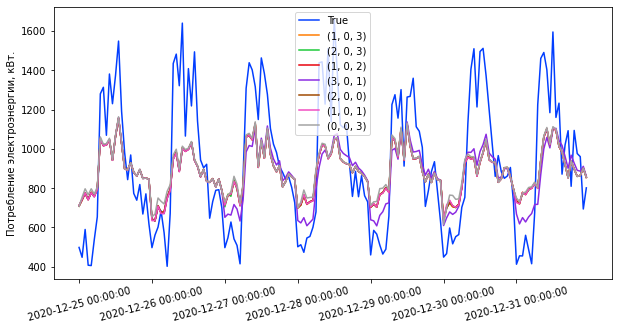

In [20]:
plt.figure(figsize=(10, 5))
colors = sns.color_palette("bright", n_colors=len(df_seasonal_arima_predictions.columns))
for i, col in enumerate(df_seasonal_arima_predictions):
    plt.plot(df_seasonal_arima_predictions[col], color=colors[i], label=col)
plt.ylabel('Потребление электроэнергии, кВт.')
plt.legend()
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

In [70]:
mape_list = [mape(y_test.values, df_seasonal_arima_predictions[col].values) for col in df_seasonal_arima_predictions.columns[1:]]
mse_list = [mse(y_test.values, df_seasonal_arima_predictions[col].values) for col in df_seasonal_arima_predictions.columns[1:]]
mae_list = [mae(y_test.values, df_seasonal_arima_predictions[col].values) for col in df_seasonal_arima_predictions.columns[1:]]
r2_list = [r2(y_test.values, df_seasonal_arima_predictions[col].values) for col in df_seasonal_arima_predictions.columns[1:]]

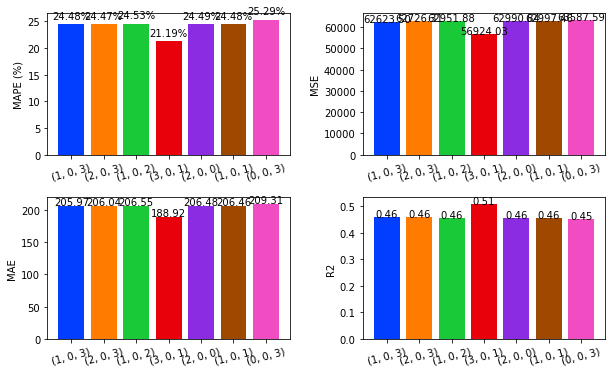

In [71]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
xnames = [str(col) for col in df_seasonal_arima_predictions.columns[1:]]

plt.subplot(2, 2, 1)
plt.bar(x=xnames, height=mape_list, color=colors)
for index, value in enumerate(mape_list):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(xnames, rotation=15)

plt.subplot(2, 2, 2)
plt.bar(x=xnames, height=mse_list, color=colors)
for index, value in enumerate(mse_list):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(xnames, rotation=15)

plt.subplot(2, 2, 3)
plt.bar(x=xnames, height=mae_list, color=colors)
for index, value in enumerate(mae_list):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(xnames, rotation=15)

plt.subplot(2, 2, 4)
plt.bar(x=xnames, height=r2_list, color=colors)
for index, value in enumerate(r2_list):
    plt.text(x=index, y=value , s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(xnames, rotation=15);

In [72]:
# sum_list = [sum(df_seasonal_arima_predictions[col]) for col in df_seasonal_arima_predictions.columns[1:]]
# plt.figure(figsize=(10, 6))
# plt.bar(x=xnames, height=sum_list, color=colors)
# plt.hlines(y=sum(y_test), xmin=-0.5, xmax=len(df_seasonal_arima_predictions.columns)-1.5, color='black', linestyles='dashed')
# for index, value in enumerate(sum_list):
#     plt.text(x=index, y=value, s=f'{value:.2f}', ha='center')
# plt.text(x=6, y=25050, s=f'sum(y_true)={sum(df_seasonal_arima_predictions["True"]):.0f}', ha='center')
# plt.ylabel('Сумма за день');

In [73]:
df_seasonal_arima_results = pd.DataFrame(None)
df_seasonal_arima_results['Model'] = [f'ARIMA{order}'for order in xnames]
df_seasonal_arima_results['MAPE'] = mape_list
df_seasonal_arima_results['MSE'] = mse_list
df_seasonal_arima_results['MAE'] = mae_list
df_seasonal_arima_results['R2'] = r2_list
df_seasonal_arima_results['Time_prediction'] = time_prediction_list
#df_seasonal_arima_results['Sum'] = sum_list
df_seasonal_arima_results.to_csv('Итог_Seasonal(P=0,Q=1)_ARIMA_модели.csv')

## Поиск p и q при P=1 и Q=1

In [74]:
col = ['Order', 'AIC', 'Prob(Q)', 'P>|z|']
col

['Order', 'AIC', 'Prob(Q)', 'P>|z|']

In [75]:
df_results = pd.DataFrame(None,
                          columns=col)
start_search = time.time()
for p_i in range(4):
    for q_i in range(4):

        try:
            model = ARIMA(y, order=(p_i, 0, q_i), seasonal_order=(1,0,1,24)).fit()
            residuals = model.resid
            res = {}
            res['Order'] = (p_i,0,q_i)
            res['AIC'] = round(model.aic, 2)
            res['Prob(Q)'] = '>0.05' if acorr_ljungbox(residuals, lags=1, return_df=True)['lb_pvalue'].values[0] > 0.05 else '<0.05'
            res['P>|z|'] = 'all' if sum(model.pvalues < 0.05)==len(model.pvalues) else 'not all'
            df_results = df_results.append(res,
                                            ignore_index=True)
            print(f'Order: ({p_i},0,{q_i})(1,0,1)[24]       AIC: {model.aic:.2f}')
        except:
            continue
end_search = time.time()
print('\n\nПеребор параметров занял: ', end_search-start_search)

Order: (0,0,0)(1,0,1)[24]       AIC: 35233.85
Order: (0,0,1)(1,0,1)[24]       AIC: 35194.16
Order: (0,0,2)(1,0,1)[24]       AIC: 35169.48
Order: (0,0,3)(1,0,1)[24]       AIC: 35144.60
Order: (1,0,0)(1,0,1)[24]       AIC: 35186.26
Order: (1,0,1)(1,0,1)[24]       AIC: 35174.11
Order: (1,0,3)(1,0,1)[24]       AIC: 35179.23
Order: (2,0,0)(1,0,1)[24]       AIC: 35195.59
Order: (2,0,2)(1,0,1)[24]       AIC: 35431.64
Order: (3,0,1)(1,0,1)[24]       AIC: 35740.71
Order: (3,0,2)(1,0,1)[24]       AIC: 35971.30


Перебор параметров занял:  343.0394654273987


In [76]:
df_results = df_results.sort_values(by='AIC', ascending=True)
df_results

,Order,AIC,Prob(Q),P>|z|
3,"(0, 0, 3)",35144.60,>0.05,all
2,"(0, 0, 2)",35169.48,>0.05,all
5,"(1, 0, 1)",35174.11,<0.05,all
6,"(1, 0, 3)",35179.23,>0.05,all
4,"(1, 0, 0)",35186.26,>0.05,all
1,"(0, 0, 1)",35194.16,<0.05,all
7,"(2, 0, 0)",35195.59,<0.05,all
0,"(0, 0, 0)",35233.85,<0.05,all
8,"(2, 0, 2)",35431.64,<0.05,not all
9,"(3, 0, 1)",35740.71,>0.05,all


In [77]:
df_good_results = df_results[df_results['P>|z|'] == 'all']
df_good_results = df_good_results[df_good_results['Prob(Q)'] == '>0.05']
df_good_results

,Order,AIC,Prob(Q),P>|z|
3,"(0, 0, 3)",35144.60,>0.05,all
2,"(0, 0, 2)",35169.48,>0.05,all
6,"(1, 0, 3)",35179.23,>0.05,all
4,"(1, 0, 0)",35186.26,>0.05,all
9,"(3, 0, 1)",35740.71,>0.05,all


In [78]:
# предсказания и замер времени на предсказание
df_seasonal_arima_predictions = pd.DataFrame(None)
df_seasonal_arima_predictions['True'] = y_test.values

time_prediction_list = []

for order in df_good_results.Order:
    print(f'\n\nOrder: {order}')
    week_pred = []
    for day in range(7):
        print(f'\nDay: {day+1}')
        
        y_pred = []
        y_for_train = list(y_list[day])
        start_pred = time.time()
        for i in range(len(y_list[day]), len(y_list[day])+24):
            try:
                model = ARIMA(y_for_train, order=order, seasonal_order=(1,0,1,24)).fit()
            except:
                model = ARIMA(y_for_train, order=order, seasonal_order=(1,0,1,24))
                model.initialize_approximate_diffuse()
                model = model.fit()

            prediction = model.predict(i)
            y_pred.append(prediction.item())
            y_for_train.extend(prediction)
            print(i)
        week_pred.extend(y_pred)

    end_pred = time.time()
    time_prediction_list.append(end_pred-start_pred)
    df_seasonal_arima_predictions[f'{order}'] = week_pred



Order: (0, 0, 3)

Day: 1
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783

Day: 2
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807

Day: 3
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831

Day: 4
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855

Day: 5
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879

Day: 6
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903

Day: 7
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927


Order: (0, 0, 2)

Day: 1
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
277

In [79]:
df_seasonal_arima_predictions

,True,"(0, 0, 3)","(0, 0, 2)","(1, 0, 3)","(1, 0, 0)","(3, 0, 1)"
0,498.574076,466.959404,462.103290,459.173785,459.578852,468.393118
1,448.325927,540.644289,503.856913,513.649596,502.236568,880.015173
2,589.959784,511.836309,512.763342,533.937699,506.882612,550.830957
3,408.063429,504.162730,502.460618,510.258819,502.373091,5486.395495
4,406.263067,503.772986,-45254.141440,496.893212,501.489463,1023.396684
...,...,...,...,...,...,...
163,1093.896979,828.719089,829.232054,820.813149,827.830394,837.181500
164,976.242006,786.727364,786.898784,787.365930,787.179939,800.175053
165,960.551132,800.239244,800.925565,800.898402,803.095585,882.675342
166,694.074945,751.904752,758.457782,3121.261918,758.646273,772.673194


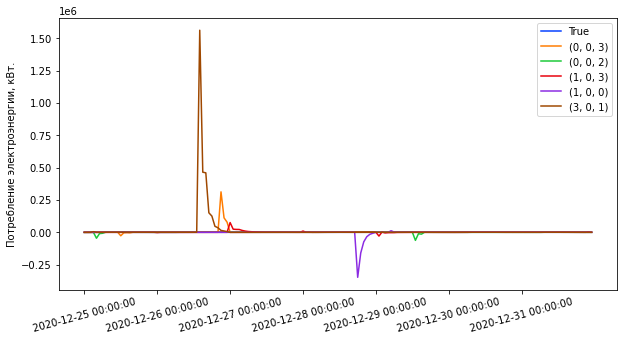

In [81]:
plt.figure(figsize=(10, 5))
colors = sns.color_palette("bright", n_colors=len(df_seasonal_arima_predictions.columns))
for i, col in enumerate(df_seasonal_arima_predictions):
    plt.plot(df_seasonal_arima_predictions[col], color=colors[i], label=col)
plt.ylabel('Потребление электроэнергии, кВт.')
plt.legend()
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

In [82]:
mape_list = [mape(y_test.values, df_seasonal_arima_predictions[col].values) for col in df_seasonal_arima_predictions.columns[1:]]
mse_list = [mse(y_test.values, df_seasonal_arima_predictions[col].values) for col in df_seasonal_arima_predictions.columns[1:]]
mae_list = [mae(y_test.values, df_seasonal_arima_predictions[col].values) for col in df_seasonal_arima_predictions.columns[1:]]
r2_list = [r2(y_test.values, df_seasonal_arima_predictions[col].values) for col in df_seasonal_arima_predictions.columns[1:]]

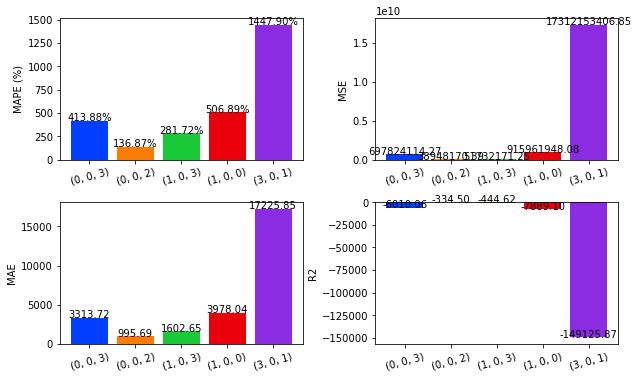

In [83]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
xnames = [str(col) for col in df_seasonal_arima_predictions.columns[1:]]

plt.subplot(2, 2, 1)
plt.bar(x=xnames, height=mape_list, color=colors)
for index, value in enumerate(mape_list):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(xnames, rotation=15)

plt.subplot(2, 2, 2)
plt.bar(x=xnames, height=mse_list, color=colors)
for index, value in enumerate(mse_list):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(xnames, rotation=15)

plt.subplot(2, 2, 3)
plt.bar(x=xnames, height=mae_list, color=colors)
for index, value in enumerate(mae_list):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(xnames, rotation=15)

plt.subplot(2, 2, 4)
plt.bar(x=xnames, height=r2_list, color=colors)
for index, value in enumerate(r2_list):
    plt.text(x=index, y=value , s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(xnames, rotation=15);

In [85]:
df_seasonal_arima_results = pd.DataFrame(None)
df_seasonal_arima_results['Model'] = [f'ARIMA{order}'for order in xnames]
df_seasonal_arima_results['MAPE'] = mape_list
df_seasonal_arima_results['MSE'] = mse_list
df_seasonal_arima_results['MAE'] = mae_list
df_seasonal_arima_results['R2'] = r2_list
df_seasonal_arima_results['Time_prediction'] = time_prediction_list
# df_seasonal_arima_results['Sum'] = sum_list
df_seasonal_arima_results.to_csv('Итог_Seasonal(P=1,Q=1)_ARIMA_модели.csv')